In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import pickle

from src.network_simulator import PoissonNetwork
from src.variational_bayes import VariationalBayes

### An example of simulating a network with nodes changing memberships

Example of a fully-connected graph

In [13]:
num_nodes = 250; num_groups = 2; num_groups_prime = 1; T_max = 5
group_sizes = np.array([150, 100])
group_sizes_prime = np.array([num_nodes])
lam_matrix = np.array([[2.0, 1.0],
                       [0.3, 8.0]]) 
rho_matrix = np.array([[1]]) # Fully-connected graph 

PN = PoissonNetwork(num_nodes=num_nodes, 
                    num_groups=num_groups, 
                    num_groups_prime=num_groups_prime,
                    T_max=T_max,
                    lam_matrix=lam_matrix,
                    rho_matrix=rho_matrix)
sampled_network, groups_in_regions = (
    PN.sample_network(group_sizes=group_sizes,
                      group_sizes_prime=group_sizes_prime,
                      mem_change=True,
                      mem_change_times=np.tile([3], 50), # Nodes all swap at time t=3
                      mem_change_nodes=np.arange(50)) # Nodes 0-49 swap
) 

Example of a graph where the adjacency matrix is formed from an SBM with two groups

In [5]:
num_nodes = 250; num_groups = 2; num_groups_prime = 2; T_max = 5
group_sizes = np.array([150, 100])
group_sizes_prime = np.array([200, 50]) # Sizes of SBM groups
lam_matrix = np.array([[2.0, 1.0],
                       [0.3, 8.0]])
rho_matrix = np.array([[0.9, 0.2],
                       [0.1, 0.7]]) # Connected probabilities 

PN = PoissonNetwork(num_nodes=num_nodes, 
                    num_groups=num_groups, 
                    num_groups_prime=num_groups_prime,
                    T_max=T_max,
                    lam_matrix=lam_matrix,
                    rho_matrix=rho_matrix)
sampled_network, groups_in_regions = (
    PN.sample_network(group_sizes=group_sizes,
                      group_sizes_prime=group_sizes_prime,
                      mem_change=True,
                      mem_change_times=np.tile([2], 50),
                      mem_change_nodes=np.arange(50))
)

### An example of simulating a network with rate changes

In [6]:
num_nodes = 250; num_groups = 2; num_groups_prime = 1; T_max = 5
group_sizes = np.array([150, 100])
group_sizes_prime = np.array([num_nodes])
lam_matrix = np.array([[2.0, 1.0],
                       [0.3, 8.0]])
rho_matrix = np.array([[1]]) # Fully-connected
rate_matrices = [
    lam_matrix,
    np.array([[5.0, 1.0],
              [0.3, 8.0]]),
    np.array([[3.0, 1.0],
              [0.3, 2.0]]),
    np.array([[6.0, 1.0],
              [0.3, 2.0]])] # Rate matrices that are changed to

PN = PoissonNetwork(num_nodes=num_nodes, 
                    num_groups=num_groups, 
                    num_groups_prime=num_groups_prime,
                    T_max=T_max,
                    lam_matrix=lam_matrix,
                    rho_matrix=rho_matrix)
sampled_network, groups_in_regions = (
    PN.sample_network(group_sizes=group_sizes,
                      group_sizes_prime=group_sizes_prime,
                      rate_change=True,
                      rate_matrices=rate_matrices, # List of the rate matrices
                      rate_change_times= np.array([3, 4, 4.5])) # Times of the rate changes
)

### An example of the number of groups changing

In [7]:
num_nodes = 250; num_groups = 2; num_groups_prime = 1; T_max = 5
group_sizes = [np.array([150, 100]), np.array([250, 0])] # Number of members of each group
group_sizes_prime = np.array([num_nodes])
lam_matrix = np.array([[2.0, 1.0],
                       [0.3, 8.0]])
rho_matrix = np.array([[1]])

PN = PoissonNetwork(num_nodes=num_nodes, 
                    num_groups=num_groups, 
                    num_groups_prime=num_groups_prime,
                    T_max=T_max,
                    lam_matrix=lam_matrix,
                    rho_matrix=rho_matrix)
sampled_network, groups_in_regions = (
    PN.sample_network(group_sizes=group_sizes,
                      group_sizes_prime=group_sizes_prime,
                      group_num_change=True,
                      group_num_change_times=np.array([3.2]) # Time of the change of groups
                      )
)

### An example of inference on a sampled network

In [14]:
adj_mat = np.ones((num_nodes, num_nodes)) # Adjust to correct adjacency (if known)
int_length = 0.1; 
delta_pi = 1; delta_rho = 1; delta_lam = 1; delta_u = 1 # BFF values
n_cavi = 3; num_fp_its = 3

VB = VariationalBayes(sampled_network=sampled_network,
                      num_groups=2, num_groups_prime=1,
                      T_max=T_max, int_length=int_length,
                      adj_mat=adj_mat, 
                      num_nodes=num_nodes, alpha_0=1., beta_0=1.,
                      sigma_0=0.5, eta_0=1., zeta_0=1., nu_0=1.,
                      gamma_0=np.array([0.99, 1.01]),
                      xi_0=np.array([0.99, 1.01]), # Initial parameter values
                      infer_graph_bool=False,
                      infer_num_groups_bool=False) 
VB.run_full_var_bayes(delta_pi=delta_pi,
                      delta_rho=delta_rho,
                      delta_lam=delta_lam,
                      delta_u=delta_u,
                      n_cavi=n_cavi,
                      num_fp_its=num_fp_its)

Examine output

In [15]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

colours = [(208/255, 28/255, 139/255),
           (241/255, 182/255, 218/255),
           (184/255, 225/255, 134/255),
           (77/255, 172/255, 38/255)]

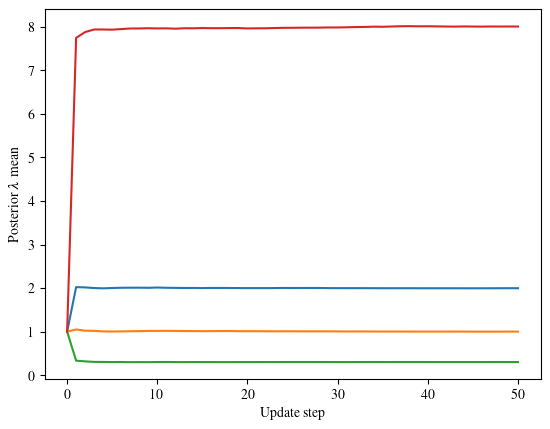

In [18]:
for k in range(num_groups):
    for m in range(num_groups):
        plt.plot(np.arange(T_max / int_length + 1), VB.alpha_store[:,k,m] / VB.beta_store[:,k,m]);

plt.xlabel('Update step');
plt.ylabel(r'Posterior $\lambda$ mean');